In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

In [3]:
raw_df = pd.read_csv('creditcard.csv')

In [4]:
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
labels = ["Genuine", "Fraud"]
fraud_or_not= raw_df["Class"].value_counts().tolist()
values = [fraud_or_not[0],fraud_or_not[1]]
fig = px.pie(values=raw_df["Class"].value_counts(),names=labels,width=700,height=400,color_discrete_sequence=['skyblue','black'],
             title= 'Fraud vs Genuine Transactions')
fig.show()


<ipython-input-6-80d7bbd6989a>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




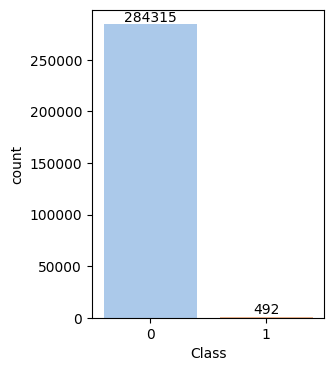

In [6]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Class',data=raw_df,palette='pastel')
for i in ax.containers:
  ax.bar_label(i,)

In [7]:
print('Genuine:',round(raw_df['Class'].value_counts()[0]/len(raw_df)*100,2),'% of the dataset')
print('Fraud:',round(raw_df['Class'].value_counts()[1]/len(raw_df)*100,2),'% of the dataset')

Genuine: 99.83 % of the dataset
Fraud: 0.17 % of the dataset


DATA Preprocessing

In [8]:
df = raw_df.copy()
df.drop_duplicates(inplace=True)
print("Duplicate values droped succesfully.")
print('-'*100)

Duplicate values droped succesfully.
----------------------------------------------------------------------------------------------------


In [9]:
df= df.drop('Time' ,axis=1)

In [10]:
numeric_columns=(list(df.loc[:,'V1':'Amount']))

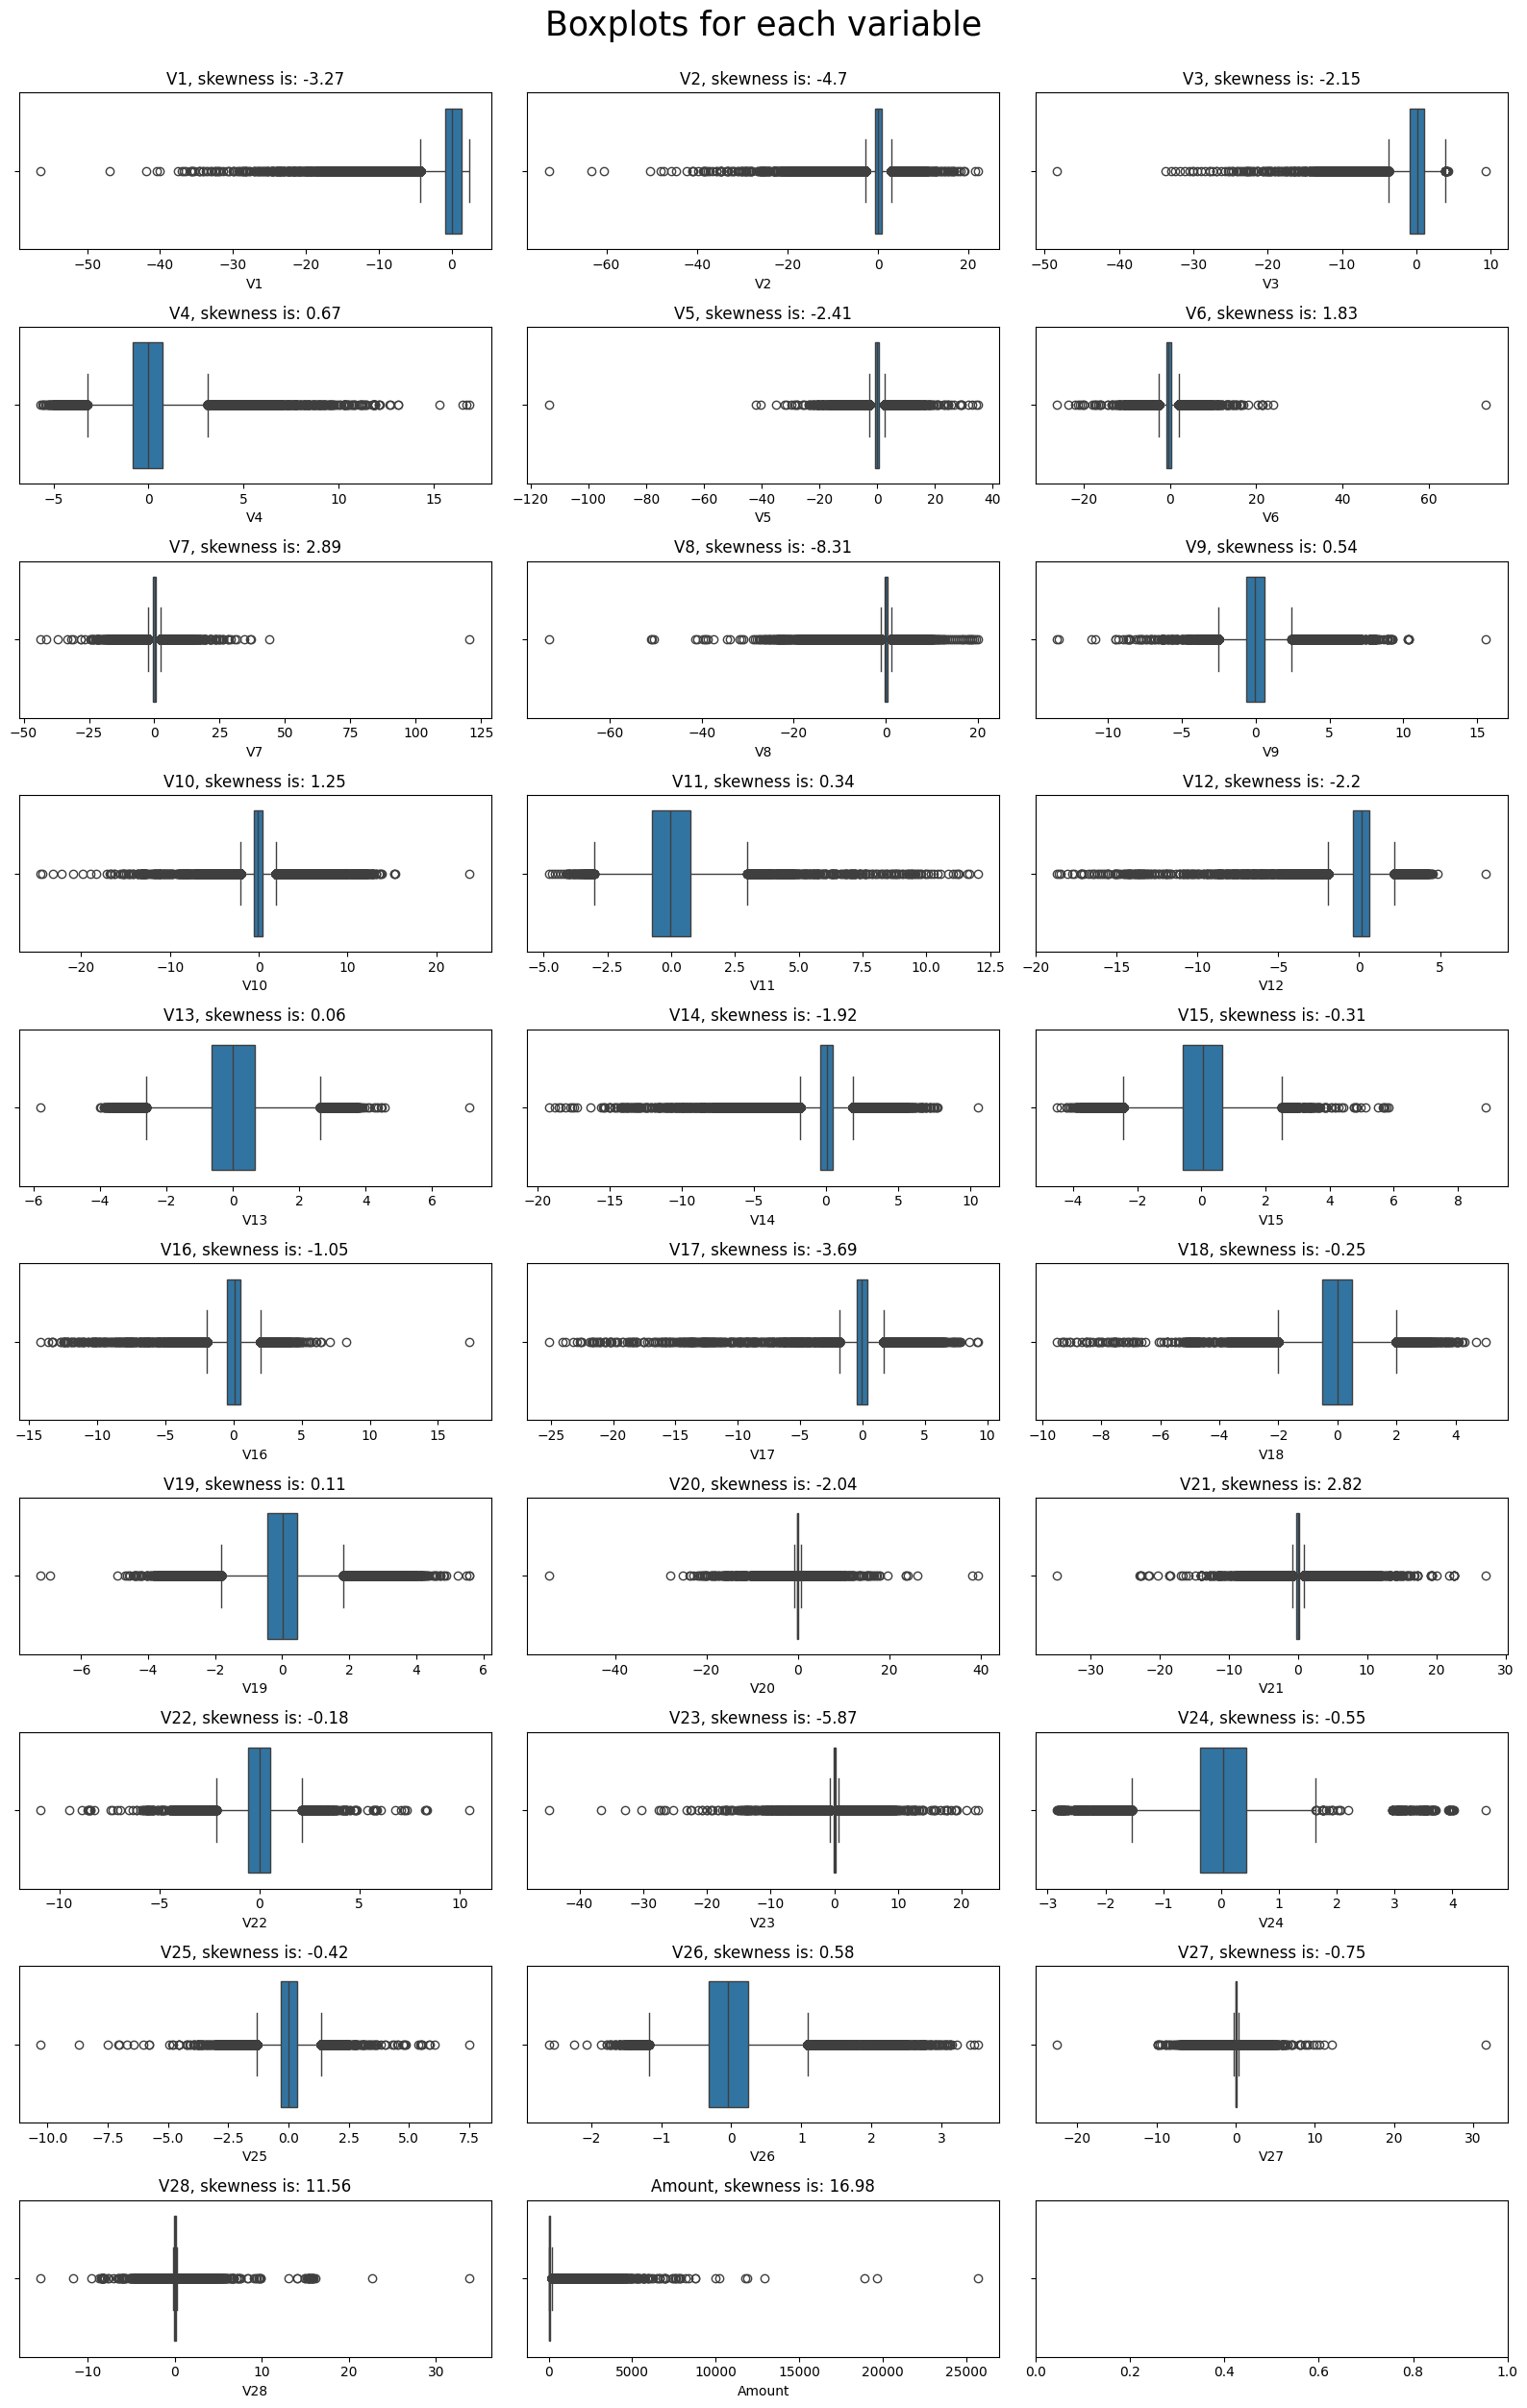

In [11]:
def boxplot_custom(dataset, columns_list, rows, cols, suptitle):
  fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16, 25))
  fig.suptitle(suptitle, y=1, size=25)
  axs = axs.flatten()
  for i, data in enumerate(columns_list):
    sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
    axs[i].set_title(data + ', skewness is: ' + str(round(dataset[data].skew(axis=0, skipna=True),2)))

boxplot_custom(dataset=df, columns_list= numeric_columns, rows = 10, cols=3, suptitle='Boxplots for each variable')

plt.tight_layout()


In [12]:
def IQR_method(df, n, features):
  outlier_list = []

  for column in features:
    Q1 = np.percentile(df[column],25)
    Q3 = np.percentile(df[column],75)

    IQR = Q3 - Q1

    outlier_step = 1.5*IQR
    outlier_list_column = df[(df[column]<Q1-outlier_step) | (df[column]>Q3+outlier_step)].index
    outlier_list.extend(outlier_list_column)

  outlier_list = Counter(outlier_list)
  multiple_outliers = list(k for k,v in outlier_list.items() if v>n)

  out1 = df[df[column]<Q1-outlier_step]
  out2 = df[df[column]>Q3+outlier_step]

  print("Total number of deleted outlier is",out1.shape[0]+out2.shape[0])

  return multiple_outliers

In [13]:
outliers_IQR = IQR_method(df, 1, numeric_columns)
df_out = df.drop(outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outlier is 31685


<ipython-input-14-fe9e597f8d32>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




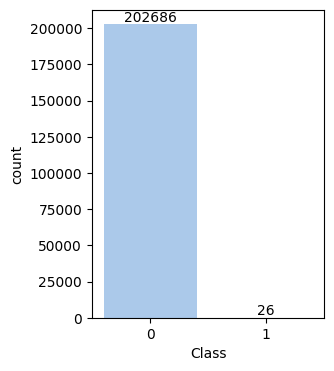

In [14]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Class',data=df_out,palette='pastel')

for i in ax.containers:
  ax.bar_label(i,)

Train-Test splite

In [15]:
X = df.drop("Class", axis=1)
y= df["Class"]

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

In [16]:
from sklearn.preprocessing import StandardScaler
def Standard_Scaler(df,col_names):
  features = df[col_names]
  scaler = StandardScaler().fit(features.values)
  features = scaler.transform(features.values)
  df[col_names] = features

  return df

In [17]:
col_names = ['Amount']
X_train = Standard_Scaler(X_train,col_names)
X_test = Standard_Scaler(X_test, col_names)

Baseline

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

kf = StratifiedKFold(n_splits=5,shuffle=False)
classifier = RandomForestClassifier(n_estimators=20,random_state=42)

In [19]:
score = cross_val_score(classifier,X_train,y_train,cv=kf,scoring='recall')
print("Cross validation recall scores are: {}".format(score))
print("Avarage cross validation recall scores are: {}".format(score.mean()))

Cross validation recall scores are: [0.78787879 0.77272727 0.7761194  0.86363636 0.57575758]
Avarage cross validation recall scores are: 0.755223880597015


Hyper Parameter Tuning

In [20]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[10,20],
    'max_depth':[4,5,6]
}

grid_rf = GridSearchCV(classifier,param_grid=params,cv=kf,scoring='recall').fit(X_train,y_train)

In [21]:
print("Best Parameters:", grid_rf.best_params_)
print("Best score:", grid_rf.best_score_)

Best Parameters: {'max_depth': 6, 'n_estimators': 20}
Best score: 0.7250113071008593


In [22]:
y_pred = grid_rf.predict(X_test)

In [23]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix
cm = confusion_matrix( y_test, y_pred)

rf_recall = recall_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test,y_pred)
rf_accuracy = accuracy_score(y_test,y_pred)

print(cm)


[[84969     7]
 [   38   104]]


In [24]:
ndf = [(rf_recall,rf_precision,rf_f1,rf_accuracy)]

rf_score =pd.DataFrame(data=ndf,columns=['recall','precision','f1','accuracy'])
rf_score.insert(0, 'Random Forest with','No under/oversampling')
rf_score

,Random Forest with,recall,precision,f1,accuracy
0,No under/oversampling,0.732394,0.936937,0.822134,0.999471


Random Sampling Imbalance Dataset

Random Oversampling

In [25]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)

X_over, y_over = ros.fit_resample(X_train,y_train)

In [26]:
print("Genuine:",y_over.value_counts()[0],'/',round(y_over.value_counts()[0]/len(y_over)*100,2),'% of the dataset')
print("Frauds:",y_over.value_counts()[1],'/',round(y_over.value_counts()[1]/len(y_over)*100,2),'% of the dataset')

Genuine: 198277 / 50.0 % of the dataset
Frauds: 198277 / 50.0 % of the dataset


Training the model on oversample dataset

In [27]:
from imblearn.pipeline import make_pipeline,Pipeline

random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42),
                                      RandomForestClassifier(n_estimators=20,random_state=13))

In [28]:
score2 = cross_val_score(random_overs_pipeline,X_train,y_train,scoring='recall',cv=kf)
print(f"Cross validation recall scores are: {score2}")
print(f"Avarage cross validation recall score is : {score2.mean()}")

Cross validation recall scores are: [0.83333333 0.72727273 0.7761194  0.84848485 0.63636364]
Avarage cross validation recall score is : 0.764314789687924


In [29]:
from sklearn.model_selection import GridSearchCV

# Assuming random_overs_pipeline and params are defined elsewhere

# Add 'randomforestclassifier__' prefix to each parameter key in params
new_params = {'randomforestclassifier__' + key: params[key] for key in params}

# Create GridSearchCV object with the specified pipeline, parameter grid, scoring, cross-validation, etc.
grid_over_rf = GridSearchCV(random_overs_pipeline, param_grid=new_params, scoring='recall', cv=kf, return_train_score=True)

# Fit the GridSearchCV object to the training data
grid_over_rf.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_estimators=20,
                                                               random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [4, 5, 6],
                         'randomforestclassifier__n_estimators': [10, 20]},
             return_train_score=True, scoring='recall')

In [30]:
print("Best Parameters:", grid_over_rf.best_params_)
print("Best score:", grid_over_rf.best_score_)

Best Parameters: {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 20}
Best score: 0.8640886476707372


In [31]:
y_pred = grid_over_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)

In [32]:
cm = confusion_matrix( y_test, y_pred)

over_rf_recall = recall_score(y_test, y_pred)
over_rf_precision = precision_score(y_test, y_pred)
over_rf_f1 = f1_score(y_test,y_pred)
over_rf_accuracy = accuracy_score(y_test,y_pred)

print(cm)


[[84529   447]
 [   25   117]]


In [33]:
ndf = [(over_rf_recall,over_rf_precision,over_rf_f1,over_rf_accuracy)]

over_rf_score =pd.DataFrame(data=ndf,columns=['recall','precision','f1','accuracy'])
over_rf_score.insert(0, 'Random Forest with','Oversampling')
over_rf_score

,Random Forest with,recall,precision,f1,accuracy
0,Oversampling,0.823944,0.207447,0.331445,0.994455


Under sampling

In [34]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

X_under,y_under = rus.fit_resample(X_train,y_train)

In [35]:
print("Genuine:",y_under.value_counts()[0],'/',round(y_under.value_counts()[0]/len(y_under)*100,2),'% of the dataset')
print("Frauds:",y_under.value_counts()[1],'/',round(y_under.value_counts()[1]/len(y_under)*100,2),'% of the dataset')

Genuine: 331 / 50.0 % of the dataset
Frauds: 331 / 50.0 % of the dataset


SMOTE (Synthotic Minority Oversampling technique)

In [36]:
from imblearn.over_sampling import SMOTE

random_smote_pipeline = make_pipeline(SMOTE(random_state=42),
                                      RandomForestClassifier(n_estimators=20, random_state=13))

In [37]:
score3 = cross_val_score(random_smote_pipeline,X_train,y_train,cv=kf,scoring='recall')
print(f"Cross validation recall scores are:{score3}")
print(f"Avarage cross validation recall score is:{score3.mean()}")

Cross validation recall scores are:[0.84848485 0.81818182 0.7761194  0.84848485 0.6969697 ]
Avarage cross validation recall score is:0.7976481230212574


In [38]:
new_params1 = {'randomforestclassifier__' + key: params[key] for key in params}

grid_smote_rf = GridSearchCV(random_smote_pipeline,param_grid=new_params1,scoring='recall',cv=kf,return_train_score=True)

grid_smote_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_estimators=20,
                                                               random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [4, 5, 6],
                         'randomforestclassifier__n_estimators': [10, 20]},
             return_train_score=True, scoring='recall')

In [39]:
print("Best Parameters:", grid_smote_rf.best_params_)
print("Best score:", grid_smote_rf.best_score_)

Best Parameters: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 20}
Best score: 0.8762098597919493


In [40]:
y_pred = grid_smote_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)

In [41]:
cm = confusion_matrix( y_test, y_pred)

smote_rf_recall = recall_score(y_test, y_pred)
smote_rf_precision = precision_score(y_test, y_pred)
smote_rf_f1 = f1_score(y_test,y_pred)
smote_rf_accuracy = accuracy_score(y_test,y_pred)

print(cm)


[[84480   496]
 [   21   121]]


In [42]:
ndf = [(smote_rf_recall,smote_rf_precision,smote_rf_f1,smote_rf_accuracy)]

smote_rf_score =pd.DataFrame(data=ndf,columns=['recall','precision','f1','accuracy'])
smote_rf_score.insert(0, 'Random Forest with','SMOTE')
smote_rf_score

,Random Forest with,recall,precision,f1,accuracy
0,SMOTE,0.852113,0.19611,0.318841,0.993926


Undersampling using Tomek link

In [43]:
from imblearn.under_sampling import TomekLinks

tomekU = TomekLinks()

X_underT, y_underT = tomekU.fit_resample(X_train, y_train)

In [44]:
print('Genuine:',y_underT.value_counts()[0],'/',round(y_underT.value_counts()[0]/len(y_underT)*100,2),'%  of the dataset')
print('Frauds:',y_underT.value_counts()[1],'/',round(y_underT.value_counts()[1]/len(y_underT)*100,2),'% of the dataset')

Genuine: 198259 / 99.83 %  of the dataset
Frauds: 331 / 0.17 % of the dataset


Combine SMOTE and Tomek Links

In [45]:
from imblearn.combine import SMOTETomek

SMOTETomek_pipeline = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')),
                                    RandomForestClassifier(n_estimators=20,random_state=13))

In [46]:
SMOTETomek_rf = SMOTETomek_pipeline
SMOTETomek_rf.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=20, random_state=13))])

In [47]:
y_pred = SMOTETomek_rf.predict(X_test)

In [48]:
cm = confusion_matrix( y_test, y_pred)

SMOTETomek_rf_recall = recall_score(y_test, y_pred)
SMOTETomek_rf_precision = precision_score(y_test, y_pred)
SMOTETomek_rf_f1 = f1_score(y_test,y_pred)
SMOTETomek_rf_accuracy = accuracy_score(y_test,y_pred)

print(cm)


[[84963    13]
 [   34   108]]


In [49]:
ndf = [(SMOTETomek_rf_recall,SMOTETomek_rf_precision,SMOTETomek_rf_f1,SMOTETomek_rf_accuracy)]

SMOTETomek_rf_score =pd.DataFrame(data=ndf,columns=['recall','precision','f1','accuracy'])
SMOTETomek_rf_score.insert(0, 'Random Forest with','SMOTETomek')
SMOTETomek_rf_score

,Random Forest with,recall,precision,f1,accuracy
0,SMOTETomek,0.760563,0.892562,0.821293,0.999448


Class Weights

In [50]:
rfb = RandomForestClassifier(n_estimators=20, random_state=13, class_weight= 'balanced')

In [51]:
score4 = cross_val_score(rfb ,X_train,y_train, scoring='recall',cv=kf)
print(f"Cross validation recall scores are: ,{score4}")
print(f"Avarage cross validation recall score is:{score4.mean()}")

Cross validation recall scores are: ,[0.74242424 0.6969697  0.74626866 0.83333333 0.56060606]
Avarage cross validation recall score is:0.7159203980099502


In [56]:
param_grid = {
    'n_estimators': [10,20,50],
    'max_depth' : [None, 10 ,20],
}

In [55]:
grid_rfb = GridSearchCV(estimator=rfb,param_grid = param_grid, scoring='recall',cv=kf,return_train_score=True)

grid_rfb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_estimators=20,
                                              random_state=13),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [10, 20, 50]},
             return_train_score=True, scoring='recall')

In [57]:
y_pred = grid_rfb.predict(X_test)

In [58]:
cm = confusion_matrix( y_test, y_pred)

grid_rfb_recall = recall_score(y_test, y_pred)
grid_rfb_precision = precision_score(y_test, y_pred)
grid_rfb_f1 = f1_score(y_test,y_pred)
grid_rfb_accuracy = accuracy_score(y_test,y_pred)

print(cm)


[[84958    18]
 [   35   107]]


In [59]:
ndf = [(grid_rfb_recall, grid_rfb_precision, grid_rfb_f1, grid_rfb_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest with', 'SMOTETomek')
rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,SMOTETomek,0.753521,0.856,0.801498,0.999377
